# TP3

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en **Material_TPs/TP3/images** a partir del template **Material_TPs/TP3/template**

- **(4 puntos)** Obtener una detección del logo en cada imagen sin falsos positivos.
- **(4 puntos)** Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo template del ítem 1.
- **(2 puntos)** Generalizar el algoritmo del ítem 2 para todas las imágenes.


Mounted at /content/drive


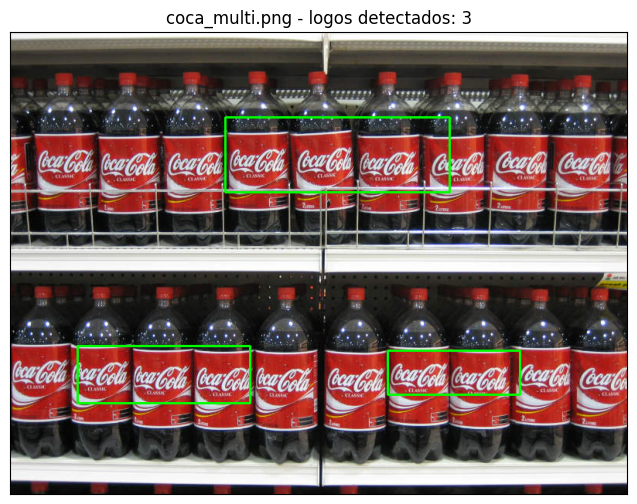

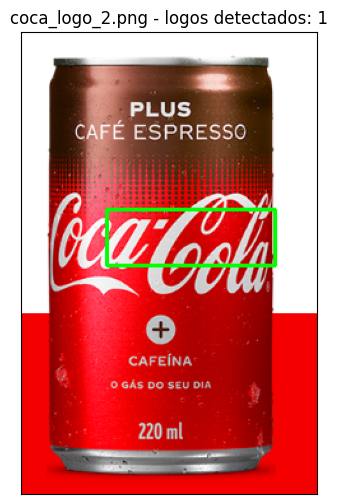

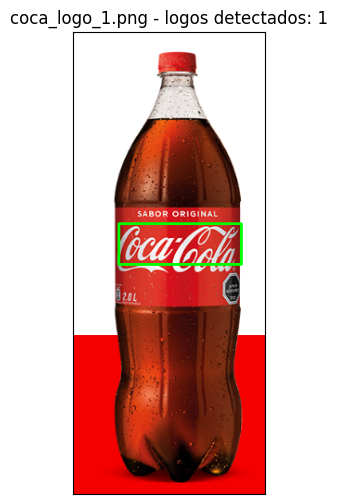

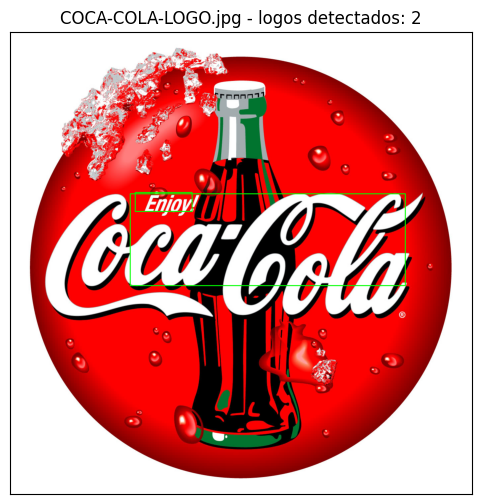

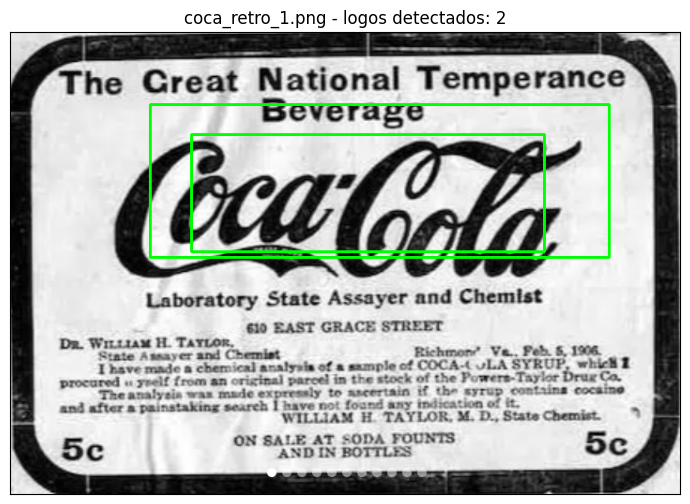

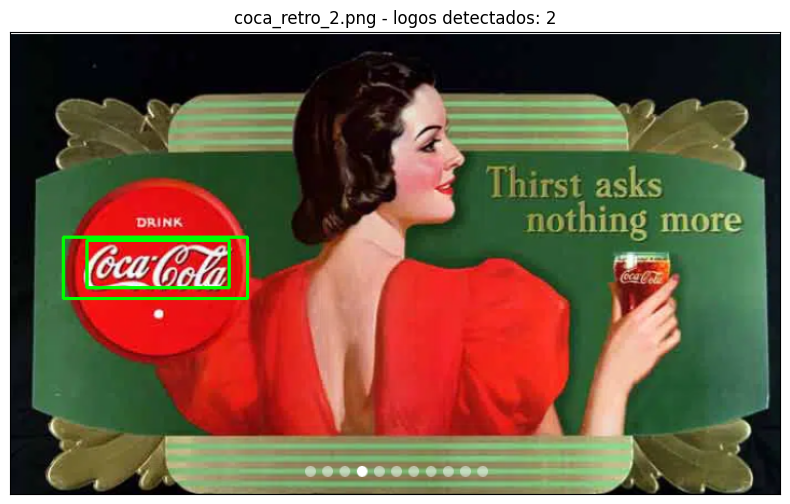

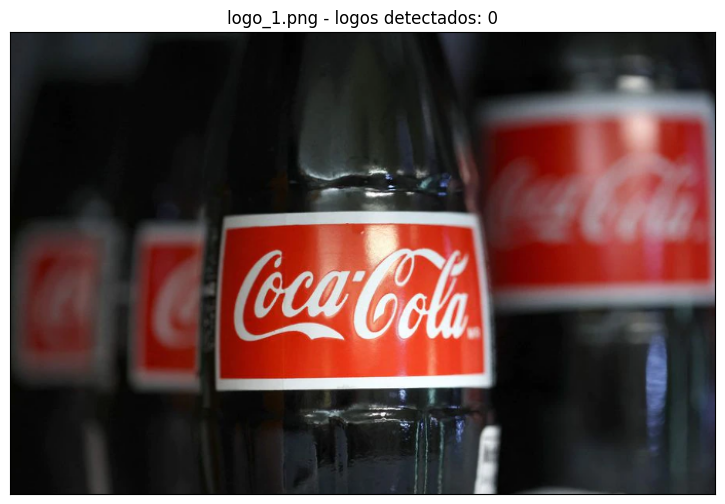

In [26]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

# Montar Google Drive
# drive.mount('/content/drive', force_remount=True)

# Rutas
# base_path = "/content/drive/MyDrive/Colab Notebooks/Material_TPs/TP3"
base_path = "/Material_TPs/TP3"
img_folder = os.path.join(base_path, "images")
template_path = os.path.join(base_path, "template", "pattern.png")
cascade_path = os.path.join(base_path, "cascade4/cascade.xml")

# Cargar template
template_orig = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
if template_orig is None:
    raise FileNotFoundError(f"No se encontró el template en {template_path}")

# Cargar cascada
cokecascade = cv2.CascadeClassifier(cascade_path)
if cokecascade.empty():
    raise FileNotFoundError(f"No se pudo cargar la cascada: {cascade_path}")

# Función template matching
def detect_logo_template(img_bgr, threshold=0.7):
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    h_img, w_img = img_gray.shape
    h_tpl, w_tpl = template_orig.shape
    scale_h = h_img / h_tpl if h_tpl > h_img else 1.0
    scale_w = w_img / w_tpl if w_tpl > w_img else 1.0
    scale = min(scale_h, scale_w)
    if scale < 1.0:
        template = cv2.resize(template_orig, (int(w_tpl*scale), int(h_tpl*scale)))
    else:
        template = template_orig

    tw, th = template.shape[::-1]
    res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= threshold)
    boxes = [(pt[0], pt[1], tw, th) for pt in zip(*loc[::-1])]
    return boxes

# Función cascada
def detect_logo_cascade(img_bgr, scaleFactor=1.3, minNeighbors=6):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    logos = cokecascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=(30,30))
    return logos

# Mostrar imagen con recuadros
def show_image_with_boxes(img, boxes, title=""):
    img_copy = img.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title(f"{title} - logos detectados: {len(boxes)}")
    plt.xticks([]), plt.yticks([])
    plt.show()

# Procesar todas las imágenes
for fname in os.listdir(img_folder):
    if not (fname.endswith(".jpg") or fname.endswith(".png")):
        continue
    img_path = os.path.join(img_folder, fname)
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        continue

    # 1️⃣ Template matching (ítem 1)
    boxes_template = detect_logo_template(img_bgr, threshold=0.7)

    # 2️⃣ Cascada entrenada (ítems 2 y 3)
    boxes_cascade = detect_logo_cascade(img_bgr)

    # Combinar recuadros
    all_boxes = boxes_template + list(boxes_cascade)

    show_image_with_boxes(img_bgr, all_boxes, title=fname)


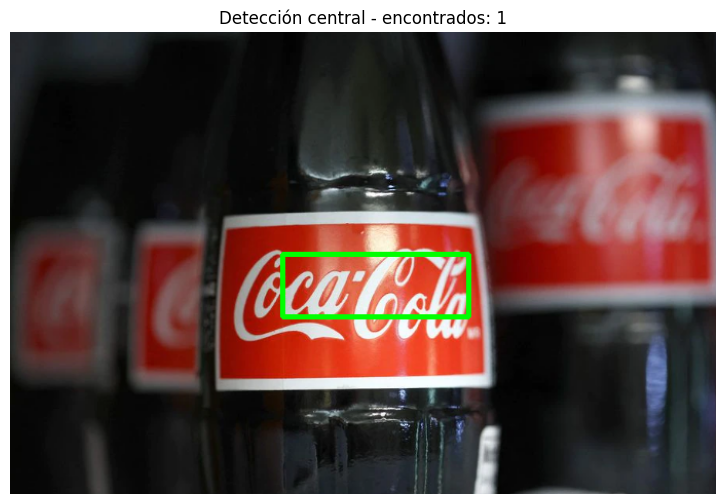

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Ruta de la imagen y de la cascada
# img_path = "/content/drive/MyDrive/Colab Notebooks/Material_TPs/TP3/images/logo_1.png"
# cascade_path = "/content/drive/MyDrive/Colab Notebooks/Material_TPs/TP3/cascade4/cascade.xml"

img_path = "/Material_TPs/TP3/images/logo_1.png"
cascade_path = "/Material_TPs/TP3/cascade4/cascade.xml"

# Cargar imagen y cascada
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError("No se pudo abrir la imagen, revisá la ruta.")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cokecascade = cv2.CascadeClassifier(cascade_path)
if cokecascade.empty():
    raise FileNotFoundError("No se pudo cargar la cascada.")

# Detectar botellas/logos
bottles = cokecascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=4, minSize=(30,30))

# Si encontró algo, elegimos el más cercano al centro
final_boxes = []
if len(bottles) > 0:
    h, w = gray.shape
    center_img = (w/2, h/2)

    def dist_to_center(box):
        x, y, bw, bh = box
        cx, cy = x + bw/2, y + bh/2
        return np.hypot(cx - center_img[0], cy - center_img[1])

    best_box = min(bottles, key=dist_to_center)
    final_boxes = [best_box]

# Dibujar resultado
output = img.copy()
for (x, y, w, h) in final_boxes:
    cv2.rectangle(output, (x, y), (x+w, y+h), (0,255,0), 3)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Detección central - encontrados: {len(bottles)}")
plt.axis("off")
plt.show()
